# True Novelties in proper motion

In this notebook I'll introduce the method used to performe the simulations for the anomalous proper motion.
For each pointing in the \opsim,  the algorithm proceeds as follows.

- We generate a set of N = $500000$ distances ${d}$ for stars within a distance range $d\sim[0,120]$kpc, according to the distance distribution in Binney 2008.
 
- We generate a set of $m_g$ for each object simulated by assigning to each object an absolute magnitude following a simplistic single-age distribution from Percival et al 2008 with stellar age $\sim 6$ Gyr (which is between the typical age of stars in the bulge and those in the disk as claimed in Sit et al 2020). Stars in the magnitude range $m_g\sim[15,25]$ are retained. 

- We select only the $1\%$ dimmer population of the entire simulated sample.

- We associate each selected object with a Galactic component assigning them in proportion to the relative density of object in each component at distance ${d}$. 

- We assign a velocity $\overrightarrow{v}$ to each selected object drawing either from the assigned Galactic component velocity distribution or from an ${unusual}$ distribution.

- Finally, we calculate the tangential velocity $v_\mathrm{tan}$, which represents the projection of the velocity vector on the sky plane, ie, its proper motion, as:
$\mu=\frac{v_{tan}}{4.74~{d}}  arcsec/yr.$


In [1]:
import sys,os, glob, time, astropy, warnings, pickle
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')
import numpy as np

import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import pandas as pd
from scipy.stats import *
from astropy.stats import histogram
from astropy.io import fits
import sklearn.mixture.gaussian_mixture as GMM
from builtins import zip
### LSST dependencies 
from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.utils.mafUtils import radec2pix
from lsst.sims.maf.utils import m52snr, astrom_precision
sys.path.append('/home/idies/LSST_OpSim/Scripts_NBs/')
from opsimUtils import *

In [2]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))

resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
surveyDuration = 1 
init = 0 
sqlconstraint = '( filter= "g" or  filter = "r" or filter="i")'
sqlconstraint+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )
sqlconstraint+=' and proposalId > 1'  #indica a cosa sono riferiti i differenti proposalId

In [4]:
nside = 16
slicer = slicers.HealpixSlicer(nside=nside)
pixelarea = hp.nside2pixarea(nside,degrees=True)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [5]:
from astrometry_metrics import sigma_slope_arr, position_selection,simulate_pm,getDataMetric,LSPMmetric,reducedPM,TransienPM

We create a csv file with the simulated objects, for each of one we have a magnitude MAG, a position in the Galaxy MODE, a distance d, a proper motion PM generate using the velocity distribution function in Binney 2009, an anomalous proper motion PM_out generated using a uniform distribution ranged between -100 and 100 km/s, 

In [7]:
simulate_pm(nexp=500000,M_min=15,M_max=25, prob_type='uniform')

simulated pm of 500000 objects


In [8]:
hstar = pd.read_csv('hypervelocity_cut.csv')
hstar.sort_values(by='MAG', ascending=False)
N = 0.01* np.size(hstar['MAG'])
cut = hstar.iloc[0:int(N)]

In [9]:
alpha= np.random.uniform(0,2*np.pi,np.size(cut['PM']))
pm_alpha, pm_delta = cut['PM']*np.sin(alpha), cut['PM']*np.cos(alpha)
pm_un_alpha, pm_un_delta = cut['PM_out']*np.sin(alpha), cut['PM_out']*np.cos(alpha)

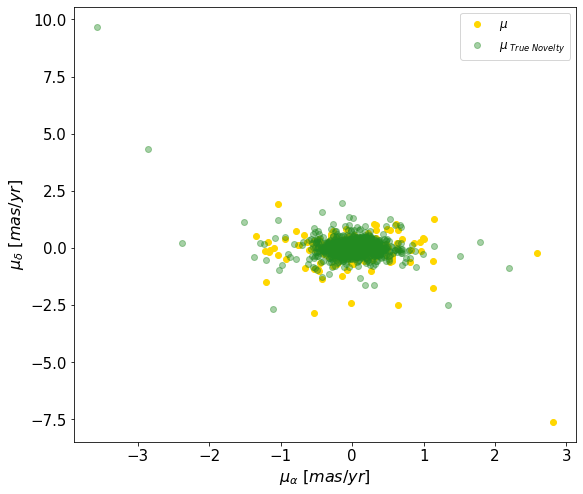

In [103]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
fig, ax = plt.subplots(1,1,figsize=(9,8))
ax.plot(pm_alpha*10**3,pm_delta*10**3,'o', color= 'gold',label = r'$\mu$')
ax.plot(pm_un_alpha*10**3,pm_un_delta*10**3,'o', color = 'forestgreen',alpha= 0.4,label = r'$\mu_{~True~Novelty}$')
ax.set_xlabel(r'$\mu_{\alpha}$ '+r'$[mas/yr]$',fontsize=16)
ax.set_ylabel(r'$\mu_{\delta}$ '+r'$[mas/yr]$',fontsize=16)
plt.legend(loc=0, fontsize=12)

In [11]:
import glob

workpath = os.getcwd()
os.chdir(dbDir)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()
dblist_all[0]

'baseline_nexp1_v1.7_10yrs.db'

In [12]:
dbname = dblist_all[0]
opsdb = db.OpsimDatabase(dbDir+dbname)
metric = getDataMetric(colname=['observationStartMJD','fiveSigmaDepth', 'filter','seeingFwhmGeom'])
# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>0.0 and night < 365.25  and proposalId > 1 for columns ['observationStartMJD', 'fiveSigmaDepth', 'seeingFwhmGeom', 'filter', 'fieldDec', 'fieldRA']
Found 5482 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [13]:
data = Sky.metricValues.data

# create DataFrame from ndarrays
df = pd.concat( [pd.DataFrame(d) for d in data], ignore_index=True)

## Likelihood Score Metric

This metric aims to measure the fraction of True Novelties without confuse it with a measure from a ${known}$ object

In [28]:
obs = np.where((df['filter']=='g') & (df['observationStartMJD']<min(df['observationStartMJD'])+365*surveyDuration))

Of all the simulated objects we consider only those whose SNR is grater than a fixed threshold

In [38]:
snr_lim = 5
snr = m52snr(cut['MAG'][:, np.newaxis],np.median(df['fiveSigmaDepth']))
row, col =np.where(snr>snr_lim)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/metrics_and_documentation/astrometry_metrics.py:30: RuntimeWarning: invalid value encountered in greater
  denom[np.where(denom > 0)] = np.sqrt(np.sum(w)*denom[np.where(denom > 0)]**-1 )


To be sure we are considering realistic proper motion, we assume that the proper motion $\mu$ has to describe a motion greater of the $5\%$ of the point-spread-function (PSF) full width half maximum (\fwhm) to be measured. 
As Kuijken at al 2002 showed, the random uncertainty on the position of a moving star measured via PSF fitting at signal-to-noise $S/N$ can be estimated as:  $\sigma_{\Delta x}= \frac{0.67 \times FWHM}{\frac{S}{N}}$. 
When comparing positions at two epochs separated by time gap $\Delta t$, the error on the proper motion $\mu$ is: 
$ \sigma_\mu=\frac{0.67\times FWHM}{\Delta t\cdot \frac{S}{N}}$


In [ ]:
precis = astrom_precision(np.median(df['seeingFwhmGeom']), snr)
sigmapm=sigma_slope_arr(np.array(df['observationStartMJD']), precis[:,np.newaxis])*365.25*1e3

In [41]:
Times = list(df['observationStartMJD'])
DeltaTs = []
while np.size(Times)>1:
    for d in range(len(Times)-1):
        DeltaTs.append(Times[d]-Times[d+1])
    Times.remove(Times[0])
DeltaTs.sort()
DeltaTs = np.array(DeltaTs)
if np.size(DeltaTs)>0:
    dt_pm = 0.05*np.median(df['seeingFwhmGeom'])/cut['PM'][np.unique(row)]
    selection = np.where((dt_pm>DeltaTs[0]) & (dt_pm<DeltaTs[-1]))

To see how many True Novelties we are able to identify as such we measure the fraction of detectable objects that cannot be confused as known ones. We do that by counting the number of measured proper motion fall outside the $3\sigma$ confidence reagion of the distribution of ${known}$ objects. 

In [42]:
mu_min,mu_max, mu_mean = np.percentile(np.array([pm_alpha, pm_delta ]),[2.5,97.5,50],axis=0)
center = [np.concatenate((mu_min,mu_max)).sum()/np.size(np.concatenate((mu_min,mu_max))), 
          pm_delta.sum()/np.size(pm_delta)]
radius = np.sqrt((np.concatenate((mu_min,mu_max))-center[0])**2+(np.concatenate((pm_delta,pm_delta)) -center[1])**2)
distance = np.sqrt((center[0]- pm_un_alpha)**2+(center[1]-pm_un_delta)**2)
outcontour= distance>radius.max()
u = np.where(outcontour==True)
res= np.size(u)/np.size(distance)

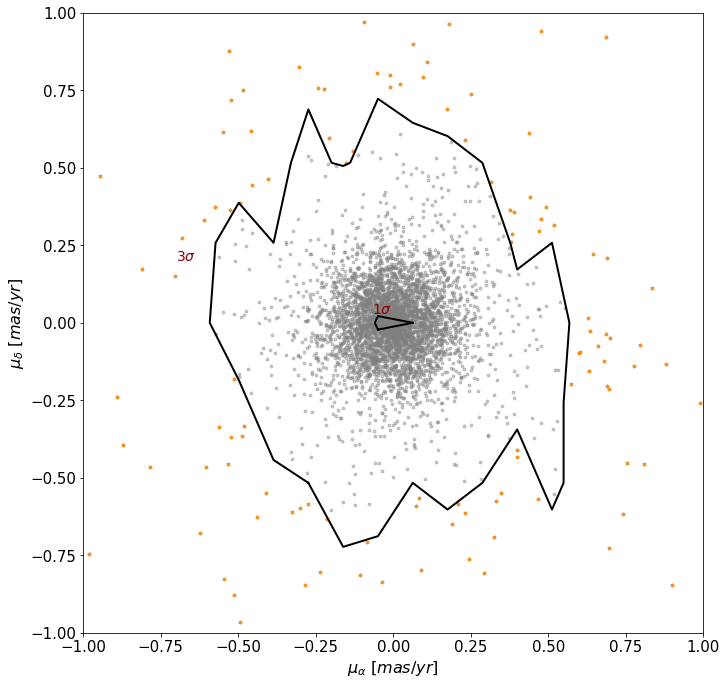

In [68]:
import scipy.optimize as so 
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
fig, ax= plt.subplots(1,1,figsize=(10,10))

ax.set(adjustable='box', aspect=1)
pm = cut['PM']*10**3 # to convert pm to mas/yr
pm_un = cut['PM_out']*10**3
nbin = 37
H, xedges, yedges = np.histogram2d(pm_alpha,pm_delta, bins=(nbin,nbin), normed=True)
x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbin))
y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbin,1))

pdf = (H*(x_bin_sizes*y_bin_sizes))

one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
levels = [three_sigma,one_sigma]#,one_sigma]

X, Y = np.meshgrid(0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1]))
Z = pdf.T


#### plot the contours

contour = ax.contour(X, Y, Z, levels=levels,colors='black',linewidths=0,extent='both')
p =contour.collections[0].get_paths()[1].vertices
p_ =contour.collections[1].get_paths()[0].vertices
c3s = Polygon(p)

points = np.column_stack((pm_un_alpha,pm_un_delta))
id_p = np.zeros(np.shape(points)[0],dtype=bool)
for k,pp in enumerate(points):
    pp = Point(pp)
    if not pp.within(c3s):
        id_p[k] = True
ax.plot(p_[:,0]*10**3,p_[:,1]*10**3,'-',color='black',lw=2)
ax.plot(p[:,0]*10**3,p[:,1]*10**3,'-',color='black',lw=2)
ax.scatter(pm_un_alpha*10**3,pm_un_delta*10**3,marker='h',s=10, color='gray',alpha=0.4)
ax.scatter(pm_un_alpha[id_p]*10**3,pm_un_delta[id_p]*10**3,marker='h',s=10, color='darkorange',alpha =0.7)
ax.text(-.7,0.2,r'$3\sigma$',  weight='bold', fontsize=14,color='darkred')
ax.text(-.07,0.03,r'$1\sigma$', weight='bold',fontsize=14,color='darkred')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel(r'$\mu_{\alpha}$ '+r'$[mas/yr]$',fontsize=16)
ax.set_ylabel(r'$\mu_{\delta}$ '+r'$[mas/yr]$',fontsize=16)

plt.tight_layout()

## Transients PM Metric

This metric aims to measure the fraction of transients that have a proper motion and can still be detected as transients, without the variability being mis-interpreted due to the motion. 

We tackle the problem simulating a varibility for the magnitude of the object simulated in the ${cut}$ variable, with the same constrains on the detectability.

In [97]:
objRate = 0.7 # how many go off per day
nObj=np.size(np.array(cut['PM'])[selection])
m0s = np.array(cut['MAG'])[selection]
t = np.array(df['observationStartMJD'])[obs] - np.array(df['observationStartMJD'])[obs].min() 
detected = 0 
m0s = np.array(cut['MAG'])[selection]
duration =np.array(dt_pm)[selection]
lc = TransienPM().lightCurve(t, t0, m0s[400],duration[400], 0.2) 
good = m52snr(lc,np.array(df['fiveSigmaDepth'])[obs])> snr_lim 

Text(0, 0.5, 'mag')

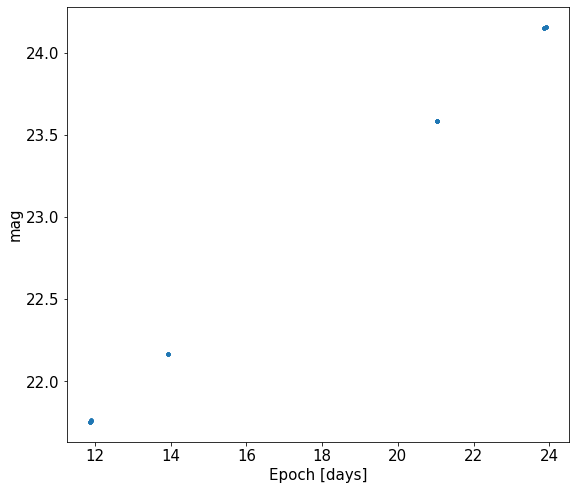

In [104]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
fig, ax = plt.subplots(1,1,figsize=(9,8))
ax.plot(t[good],lc[good],'.')
ax.set_xlabel('Epoch [days]',fontsize=15)
ax.set_ylabel('mag',fontsize=15)

Loop though each generated transient and decide if it was detected.

In [81]:
for i,t0 in enumerate(np.random.uniform(0,surveyDuration,nObj)): 
    duration =np.array(dt_pm)[selection][i]
    slope = np.random.uniform(-3,3) 
    lc = TransienPM().lightCurve(t, t0, m0s[i],duration, slope) 
    good = m52snr(lc,np.array(df['fiveSigmaDepth'])[obs])> snr_lim 
    detectTest = np.array(df['fiveSigmaDepth'])[obs] - lc 
    if detectTest.max() > 0 and len(good)>2: 
         detected += 1 
 # Return the fraction of transients detected , 
if float(nObj) == 0:
    A = np.inf 
else: 
    A=float(nObj) 
    res = float(np.sum(detected))/A

/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/utils/astrometryUtils.py:52: RuntimeWarning: overflow encountered in power
  snr = 5.*10.**(-0.4*(m-m5))


In [83]:
res

0.3035863219349458

## Confusion Metric

This metric aims to measure the accuracy of the proper motion measurements and the possibility to be able detecting anomalous structure such as streams. To do that we used data from Carlin et al 2012 where they find in Sgr A the presence of an anomalous stream. Here we repeat the experiment using the constraints we have used through all this notebook. 

In [119]:
#SgrA data
colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX'] 
data = reducedPM().readfile('data.csv', colsname)
data['MAG']=data['g']
snr_lim = 5
snr = m52snr(data['PM'][:, np.newaxis],np.median(df['fiveSigmaDepth']))
row, col =np.where(snr>snr_lim)
precis = astrom_precision(np.median(df['seeingFwhmGeom']), snr)
sigmapm=sigma_slope_arr(np.array(df['observationStartMJD']), precis[:,np.newaxis])*365.25*1e3
Times = list(df['observationStartMJD'])
DeltaTs = []
while np.size(Times)>1:
    for d in range(len(Times)-1):
        DeltaTs.append(Times[d]-Times[d+1])
    Times.remove(Times[0])
DeltaTs.sort()
DeltaTs = np.array(DeltaTs)
if np.size(DeltaTs)>0:
    dt_pm = 0.05*np.median(df['seeingFwhmGeom'])/data['MAG'][np.unique(row)]
    selection = np.where((dt_pm>DeltaTs[0]) & (dt_pm<DeltaTs[-1]))

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/metrics_and_documentation/astrometry_metrics.py:30: RuntimeWarning: invalid value encountered in greater
  denom[np.where(denom > 0)] = np.sqrt(np.sum(w)*denom[np.where(denom > 0)]**-1 )


We ask two questions: 

- if the stream were fainter could we still detect it?

- could we detect it were farther away?
 

In [120]:
dm = 2
mode = 'distance'
if mode == 'distance': 
    pmnew= data['PM']/(10**(dm/5)) 
    mag = data['MAG']+dm
elif mode == 'density': 
    pmnew= data['PM'] 
    mag = data['MAG'] + dm

To reproduce the experiment in Carlin et al 2012 we need to project the data in the reduced PM diagram: a phase space of $H_g=g+5\log\mu +5$ versus $g-r$ color

In [121]:
gr = np.random.choice(np.array(data['g-r']),size= np.size(selection))
Hg = np.array(mag)[selection]+5*np.log10(np.array(pmnew)[selection])-10

Finally we estimate the axis of the error ellipse to measure its area, and then we avarege this fraction over all the points in the phase space.

In [128]:
sigmapm[selection][np.isnan( sigmapm[selection])]=0
sigmaHg = np.sqrt((np.array(mag)[selection]/m52snr(np.array(mag)[selection],np.median(df['fiveSigmaDepth'])))**(2)+ (4.715*np.nanmean(sigmapm[selection],axis=1)/np.ceil(np.array(pmnew)[selection]))**2) 
sigmag = np.sqrt((np.array(mag)[selection]/m52snr(np.array(mag)[selection],np.median(df['fiveSigmaDepth'])))**2+((np.array(mag)[selection]-gr)/m52snr((np.array(mag)[selection]-gr),np.median(df['fiveSigmaDepth'])))**2)
CI = np.array([np.nansum((([gr-gcol ])/sigmag)**2 + ((Hg-h)/sigmaHg)**2 <= 1)/np.size(np.array(pmnew)[selection]) for (gcol,h) in zip(gr,Hg)])
np.median(CI)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


To take into account the fact that not only the accuracy of the measures per se it is important, but also the number of measurable proper motion is fundamental to discover new structures, we consider as output the following variable:

In [132]:
res=(np.size(np.array(pmnew)[selection])/np.size(pmnew))/np.mean(CI)
res

3.943691898128608